In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import log
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

target = 100
isf = 80

In [2]:
# Parkes Error Grid
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/

risk = {
    "A" : 0,
    "B" : 1,
    "C" : 2,
    "D" : 3,
    "E" : 4
}

parkes_lines = [
  [[0, 35, 50], [150, 155, 550], "E", "E"],
  [[0, 25, 50, 80, 125], [100, 100, 125, 215, 550], "D", "D"],
  [[0, 30, 50, 70, 260], [60, 60, 80, 110, 550], "C", "C"],
  [[0, 30, 140, 280, 430], [50, 50, 170, 380, 550], "B", "B"],
  [[0, 550], [0, 550], "A", "A"],
  [[50, 50, 170, 385, 550], [0, 30, 145, 300, 450], "B", "A"],
  [[120, 120, 260, 550], [0, 30, 130, 250], "C", "B"],
  [[250, 250, 550], [0, 40, 150], "D", "C"]
]


In [3]:

def above_line(x, y, actual, predicted):
    vertices = list(zip(x, y))
    above_a_segment = False
    for segment in list(zip(vertices, vertices[1:])):
        #print("Looking at segment", segment)
        ((x1, y1), (x2, y2)) = segment
        if x1 == x2 and actual < x1:
            above_a_segment = True
            break
            
        if x1 > actual:
            continue
            
        if actual > x2:
            continue

        y_line = ((y1 - y2) * actual + y2 * x1 - y1 * x2) / (x1 - x2)
        #print("y_line = ", y_line)
        if predicted < y_line:
            #print("is below segment")
            return False
        above_a_segment = True
        #print("is above segment")
    #if above_a_segment:
    #    print("is above line")
    return above_a_segment

def error_risk_parkes(actual,predicted):
    with np.nditer([actual, predicted, None]) as it:
        for a, p, y_out in it:
            #print("a = %s" % a)
            #print("p = %s" % p)
            found = False
            for line in parkes_lines:
                #print("Testing for %s" % line[2])
                if above_line(line[0], line[1], a, p):
                    #print("output = %s" % risk[line[2]])
                    y_out[...] = risk[line[3]]
                    found = True
                    break
            if not found:
                #print("outputx = 0")
                y_out[...] = 3
                
        return it.operands[2]



/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


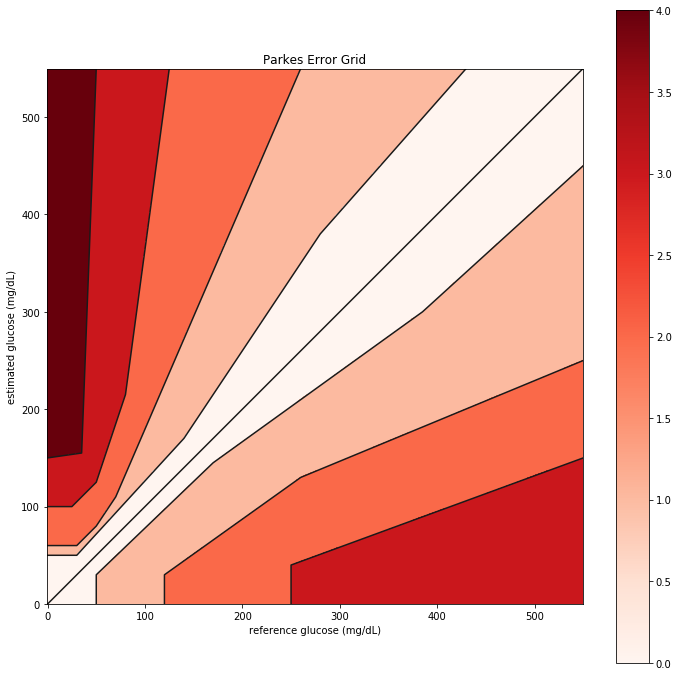

In [4]:
plt.figure(figsize=(12,12))

r = arange(0,550,1)
grid_x, grid_y = meshgrid(r, r) # grid of point
parkes_risk_vals = error_risk_parkes(grid_x, grid_y) # evaluation of the function on the grid

for line in parkes_lines:
    plt.plot(line[0], line[1], label=line[2], color=(0.1,0.1,0.1))


im = imshow(parkes_risk_vals,cmap=plt.get_cmap("Reds"), origin="lower") # drawing the function
colorbar(im) # adding the colorbar on the right
title('Parkes Error Grid')
plt.xlabel('reference glucose (mg/dL)')
plt.ylabel('estimated glucose (mg/dL)')

show()

In [48]:
# Utility functions for generating and comparing alternative risk grids

def generate_grid(proposal):
    r = arange(0,550,1)
    grid_x, grid_y = meshgrid(r, r) # grid of point
    risk_vals = proposal(grid_x, grid_y) # evaluation of the function on the grid

    # Scale to 0-5
    return risk_vals * (5.0/risk_vals.max())

def plot_grid(risk_vals, name):
    plt.figure(figsize=(12,12))
    for line in parkes_lines:
        plt.plot(line[0], line[1], label=line[2], color=(0.1,0.1,0.1))

    im = imshow(risk_vals,cmap=plt.get_cmap("Reds"), vmax=4, origin="lower") # drawing the function
    colorbar(im) # adding the colorbar on the right
    title(name)
    plt.xlabel('reference glucose (mg/dL)')
    plt.ylabel('estimated glucose (mg/dL)')
    show()
    
def plot_risk_comparison(risk_a, risk_b, name_a, name_b):
    diff = risk_a - risk_b

    plt.figure(figsize=(12,12))

    im = imshow(diff,cmap=plt.get_cmap("PuOr"), origin="lower", vmax=2, vmin=-2) # drawing the function
    colorbar(im)
    title('Comparison between %s and %s' % (name_a, name_b))
    plt.xlabel('reference glucose (mg/dL)')
    plt.ylabel('estimated glucose (mg/dL)')
    show()

    print("Min:", np.min(diff))
    print("Min:", np.max(diff))
    print("Avg:", np.mean(diff))
    print("Std:", np.std(diff))



In [ ]:
# Simple difference function
def risk_simple_difference(actual,predicted):
    return np.abs(actual-predicted)

risk_vals = generate_grid(risk_simple_difference)
plot_grid(risk_vals, "Simple Difference")
plot_risk_comparison(risk_vals, parkes_risk_vals, "Simple Difference", "Parkes")


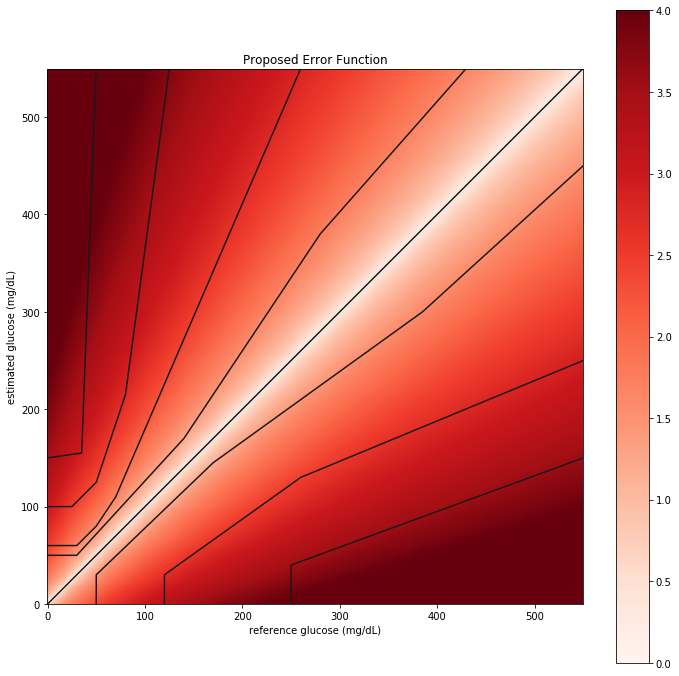

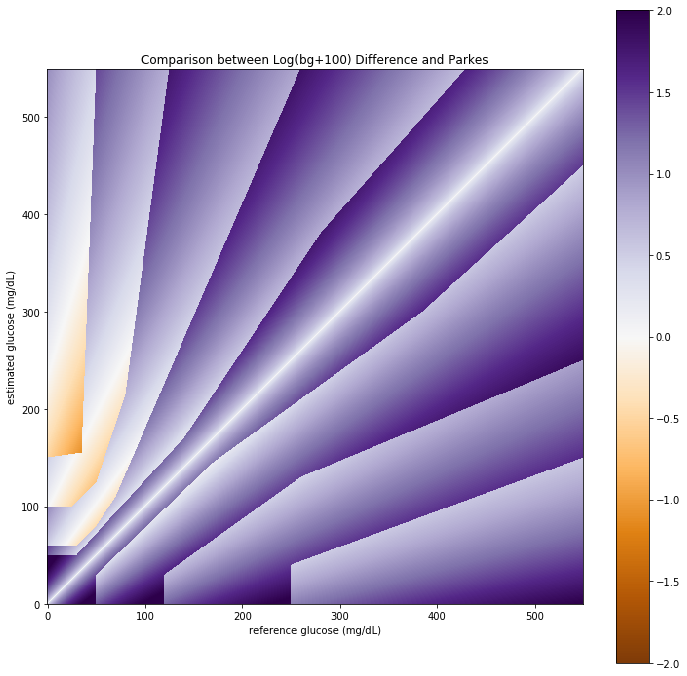

Min: -1.08429594933237
Min: 2.3087839222541904
Avg: 0.9705881198201509
Std: 0.45431744166200494


In [44]:
# Difference of log bg values
def risk_log_difference(actual,predicted):
    return np.sqrt(np.abs(np.log(actual+100)-np.log(predicted+100)))

risk_vals = generate_grid(risk_log_difference)
plot_grid(risk_vals)
plot_risk_comparison(risk_vals, parkes_risk_vals, "Log(bg+100) Difference", "Parkes")

